## CNN-Project - CIFAR 

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class. 

## Get the Data

In [20]:
# import os
# os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Put file path as a string here
CIFAR_DIR = 'cifar-10-batches-py/'

In [21]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [22]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']

In [23]:
all_data = [0,1,2,3,4,5,6]

In [24]:
#configuring the path
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [25]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]

In [26]:
batch_meta

{b'num_cases_per_batch': 10000,
 b'label_names': [b'airplane',
  b'automobile',
  b'bird',
  b'cat',
  b'deer',
  b'dog',
  b'frog',
  b'horse',
  b'ship',
  b'truck'],
 b'num_vis': 3072}

In [27]:
# Each of the batch fiels contains a dictonary with the folowing elements
data_batch1.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

### Display a single image using matplotlib.

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [29]:
X = data_batch1[b"data"]

# reshaping
X = X.reshape(10000,3,32,32).transpose(0,2,3,1).astype("uint8")

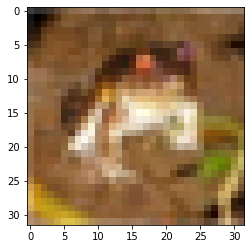

In [30]:
plt.imshow(X[0])

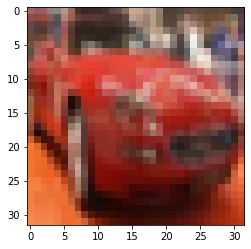

In [31]:
plt.imshow(X[5])

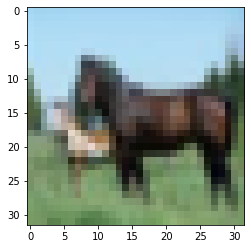

In [32]:
plt.imshow(X[12])

# Helper Functions for Dealing With Data.

In [33]:
def one_hot_encode(vec,vals=10):
    '''
    For use to one-hot encode the 10- possible labels
    '''
    n = len(vec)
    out = np.zeros((n,vals))
    out[range(n),vec] = 1
    return out

In [34]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        # Grabs a list of all the data batches for training
        self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        # Grabs a list of all the test batches (really just one batch)
        self.test_batch = [test_batch]
        
        # Intialize some empty variables for later on
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [35]:
#initilize the CifarHelper class
ch = CifarHelper()
ch.set_up_images()
batch = ch.next_batch(100)

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model

In [36]:
import tensorflow as tf

#placehoders

x = tf.placeholder(tf.float32,shape = [None,32,32,3])
y_true = tf.placeholder(tf.float32,shape = [None,10])
hold_prob = tf.placeholder(tf.float32)

### Helper Functions:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b



### Creating the Layers

In [37]:
#first layer
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

#second layer 
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

#flattened layer
convo_2_flat = tf.reshape(convo_2_pooling,[-1,8*8*64])

#full layer
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

#dropout layer - avoid overfitting
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

y_pred = normal_full_layer(full_one_dropout,10)

#Loss function
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

#Optimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

init = tf.global_variables_initializer()

## Graph Session

In [38]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for i in range(1000):
        batch = ch.next_batch(100)
        sess.run(train, feed_dict={x: batch[0], y_true: batch[1], hold_prob: 0.5})
       
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels,hold_prob:1.0}))
            print('\n')

Currently on step 0
Accuracy is:
0.1101


Currently on step 100
Accuracy is:
0.397


Currently on step 200
Accuracy is:
0.4689


Currently on step 300
Accuracy is:
0.4975


Currently on step 400
Accuracy is:
0.5146


Currently on step 500
Accuracy is:
0.5323


Currently on step 600
Accuracy is:
0.5525


Currently on step 700
Accuracy is:
0.5561


Currently on step 800
Accuracy is:
0.5779


Currently on step 900
Accuracy is:
0.5789


